# Ground up solution

First of all, this solution is built on the idea to practise the complete workflow of machine learning prediction. Even though auto ML and blending other people's results are frequently used and legit in Kaggle, I think building a ground up solution is beneficial for gaining really solid understanding of the ML techniques.

Since my computer is not powerful enough to handle the size of data here (100K times 50) with ease, I will strive for simple and efficient way to build the classification model on Kaggle hosting server. Again, the modelling process here is for learning the ML process rather than doing the fancy stuff or building specific solutions that are not ready for generalisation to other problems.

Based on the background above, you will see a solution in favour of simple ML workflow and low computation cost, ready to be deployed for different problems. The presentation may be raw, but I will keep it to show how the result is improved gradually.

Workflow:
1. Data Exploration
2. Data Preprocessing
3. Feature Engineering
4. Feature Selection
5. Model Validation And Selection
6. Hyperparameter Tuning


# Preparation

## Imports

In [1]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesClassifier, StackingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, validation_curve
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
os.listdir("../input/")

['tps-may-2021', 'tabular-playground-series-may-2021']

## Read data

In [2]:
# Read in the dataset as a dataframe
train = pd.read_csv("../input/tabular-playground-series-may-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-may-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-may-2021/sample_submission.csv")

#train.info()
#test.info()
#submission.info()

## Split datasets

In [3]:
# Split features and labels
train_labels = train['target'].reset_index(drop=True)
train_features = train.drop(['id','target'], axis=1)
test_features = test.drop(['id'], axis=1)
train_labels.head()

0    Class_2
1    Class_1
2    Class_1
3    Class_4
4    Class_2
Name: target, dtype: object

# Data Exploration

## Target distribution

As observed, 57% of the target in the training set is of "Class 2", which is moderately imbalanced.

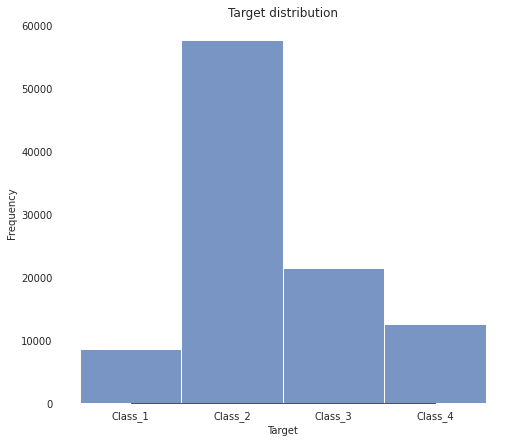

In [4]:

sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.histplot(train['target'].sort_values(), color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Target")
ax.set(title="Target distribution")
sns.despine(trim=True, left=True)
plt.show()


In [5]:
train['target'].value_counts().sort_values(ascending=False)/sum(train['target'].value_counts())

Class_2    0.57497
Class_3    0.21420
Class_4    0.12593
Class_1    0.08490
Name: target, dtype: float64

## Features EDA

No specific pattern is observed in this case.

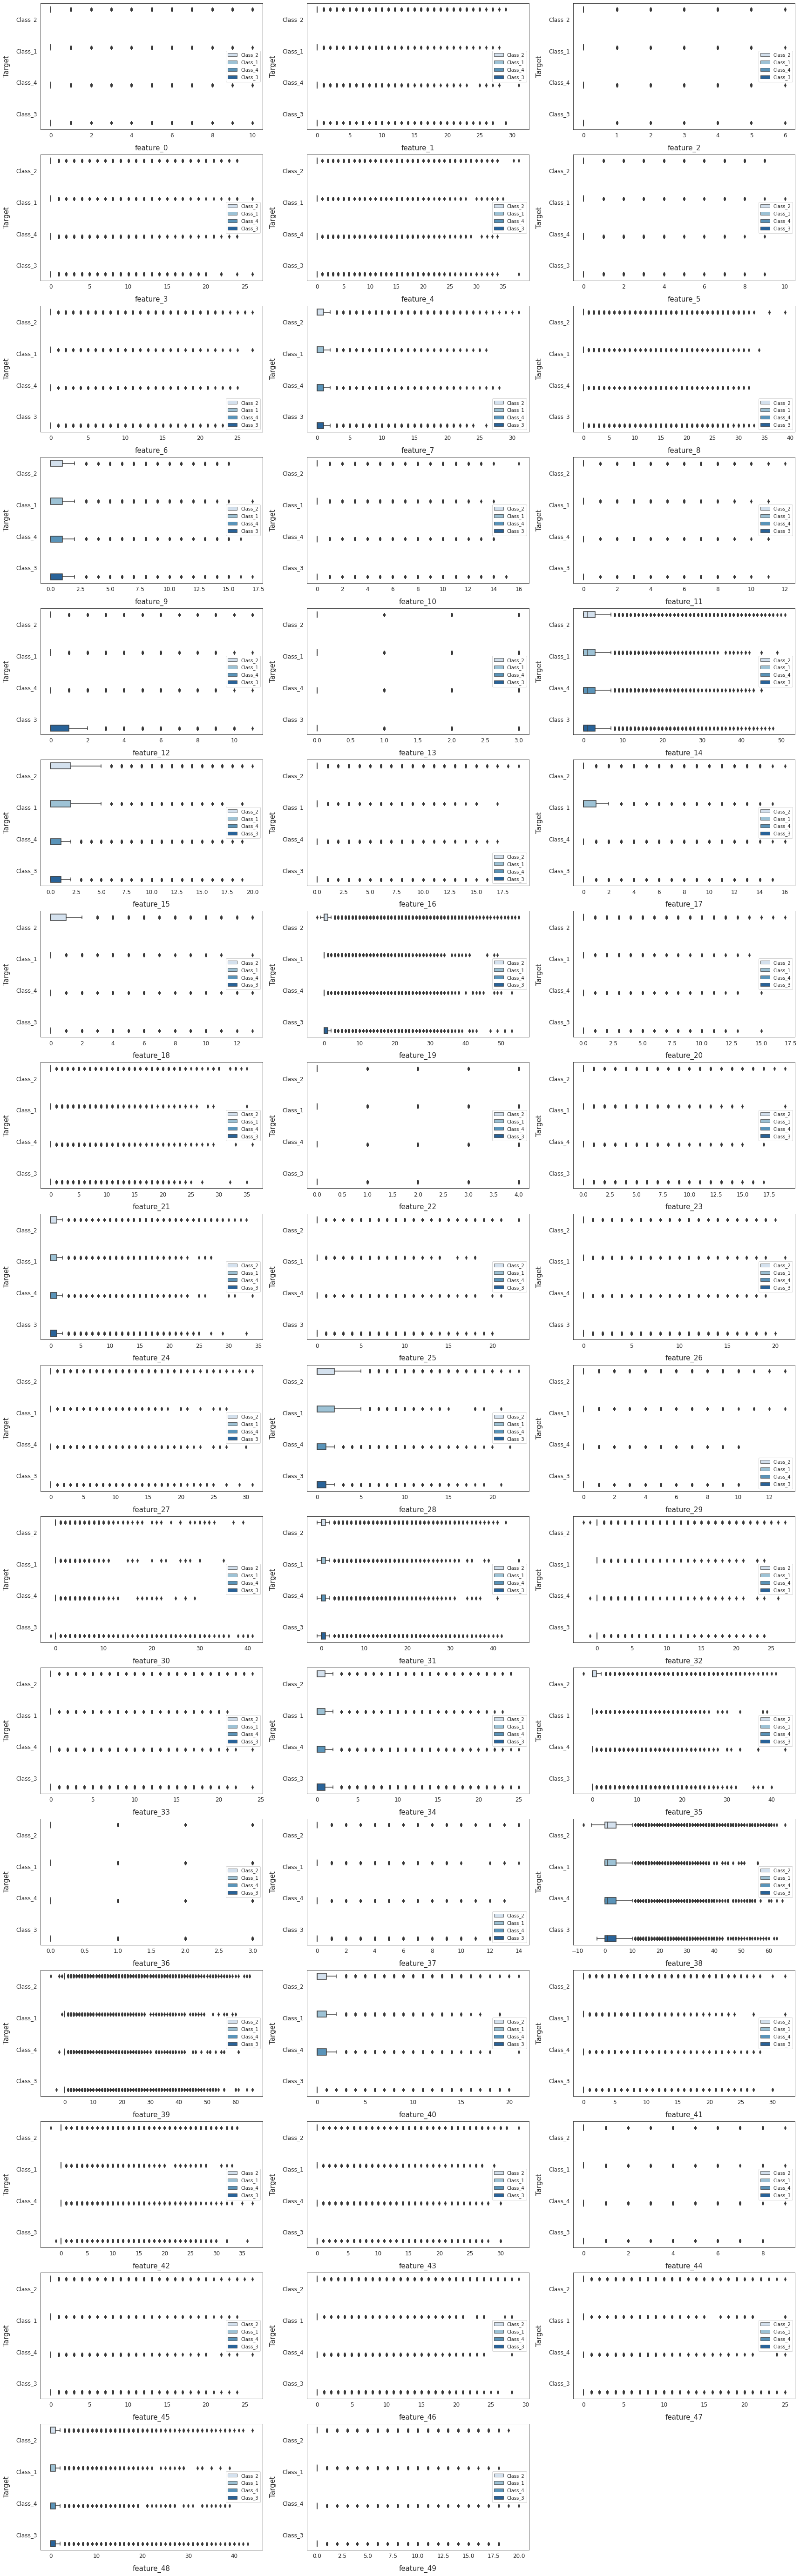

In [6]:

# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train_features), 1):
    plt.subplot(len(list(train_features)), 3, i)
    sns.boxplot(x=feature, y=train_labels, hue=train_labels, palette='Blues', data=train_features)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('Target', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()


## Correlation

Filter by RF feature importance first when the number of features is too large.

The 50 features show no significant correlation with each other.

In [7]:

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model = rf.fit(train_features, train_labels)
#rf_pred = rf_model.predict_proba(test_features)

forest_importances = pd.Series(rf.feature_importances_, index=train_features.columns)
top_feat = forest_importances.sort_values(ascending = False).head(20)
top_feat

train_features[top_feat.index]


,feature_38,feature_14,feature_7,feature_31,feature_24,feature_48,feature_34,feature_9,feature_28,feature_19,feature_15,feature_40,feature_17,feature_3,feature_21,feature_8,feature_35,feature_18,feature_49,feature_41
0,0,0,0,0,0,0,1,0,0,0,0,3,6,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0
2,3,1,0,0,1,2,2,2,2,1,0,0,0,0,5,0,0,0,0,0
3,4,7,3,0,0,1,1,0,1,1,11,0,0,0,0,0,0,3,0,0
4,1,2,0,1,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,2,5,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0
99996,7,4,1,2,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
99997,5,0,0,0,0,2,0,4,4,1,0,0,0,0,0,0,0,0,0,0
99998,1,2,0,0,2,4,0,5,1,0,0,0,0,0,0,0,0,3,0,0


<AxesSubplot:>

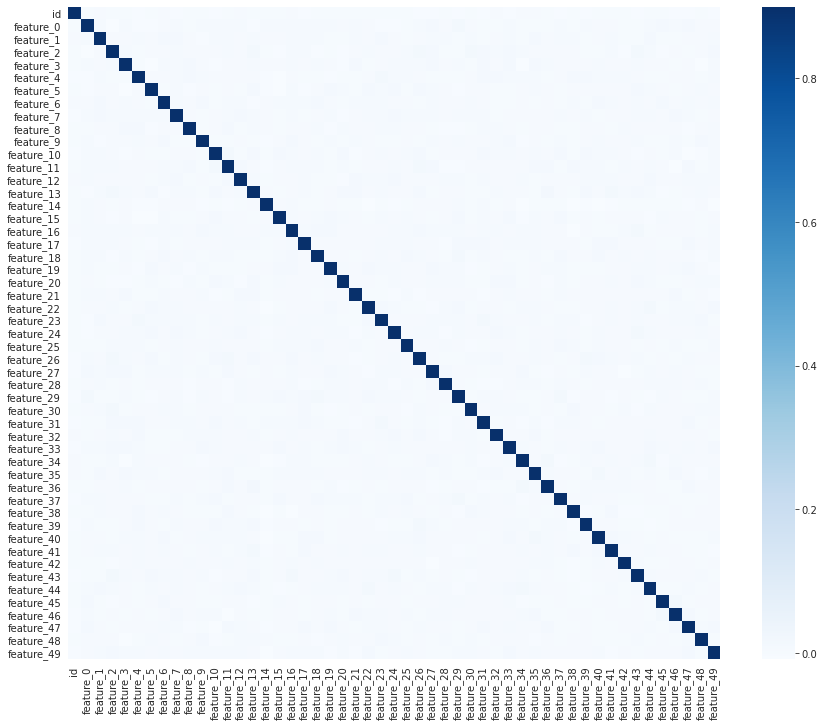

In [8]:

#corr = train_features[top_feat.index].corr()
#corr
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)


### Further exploration for high correlation to target

The most important features by RF is feature_38, but visually its standalone correlation with the target is insignificant.

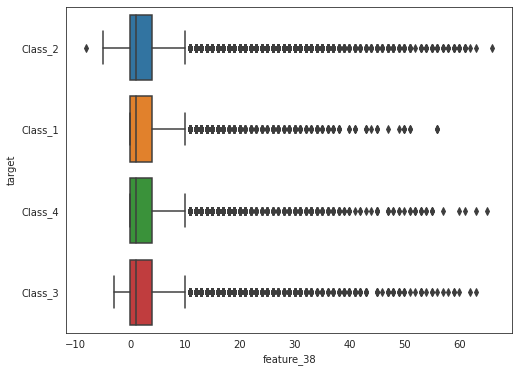

In [9]:

data = pd.concat([train['feature_38'], train['target']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['feature_38'], y="target", data=data)
#fig.axis(ymin=0, ymax=800000);


# Data Preprocessing

No outliers or missing values observed from EDA.

## Recombine datasets

No treatment is needed in this case.

# Feature Engineering

Observed that the training set has large amount of zero values in the original 50 features, I have tried to add 50 binary features depending on whether each of the original 50 features is zero or not. The trial does not provide significant improvement in preliminary RF model, so this idea is not adopted. There maybe information loss in grouping all nonzero values together, which leads to worse performance.

In [10]:
'''
# feature of zero or nonzero values

def zeroornot(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l] == 0).astype(int)) 
        res.columns.values[m] = l + '_zero'
        m += 1
    return res

train_features_zero = zeroornot(train_features, train_features.columns.tolist())
test_features_zero = zeroornot(test_features, test_features.columns.tolist())
'''

"\n# feature of zero or nonzero values\n\ndef zeroornot(res, ls):\n    m = res.shape[1]\n    for l in ls:\n        res = res.assign(newcol=pd.Series(res[l] == 0).astype(int)) \n        res.columns.values[m] = l + '_zero'\n        m += 1\n    return res\n\ntrain_features_zero = zeroornot(train_features, train_features.columns.tolist())\ntest_features_zero = zeroornot(test_features, test_features.columns.tolist())\n"

In [11]:
#train_features_zero = train_features_zero.drop(train_features_zero.iloc[:,0:50], axis=1)
#test_features_zero = test_features_zero.drop(test_features_zero.iloc[:,0:50], axis=1)

## PCA

Since there are 50 features, the dimension reduction technique may help. I have tried PCA, but the result is not satisfactory. This is intuitive given the low features correlation shown in EDA, and the almost identical contributions from all the principal components.

In [12]:
'''
X=train_features
# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()
'''

'\nX=train_features\n# Standardize\nX_scaled = (X - X.mean(axis=0)) / X.std(axis=0)\n\n# Create principal components\npca = PCA()\nX_pca = pca.fit_transform(X_scaled)\n\n# Convert to dataframe\ncomponent_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]\nX_pca = pd.DataFrame(X_pca, columns=component_names)\n\nX_pca.head()\n'

In [13]:
'''
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings
'''

'\nloadings = pd.DataFrame(\n    pca.components_.T,  # transpose the matrix of loadings\n    columns=component_names,  # so the columns are the principal components\n    index=X.columns,  # and the rows are the original features\n)\nloadings\n'

In [14]:
'''
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 0.05)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

# Look at explained variance
plot_variance(pca);
'''

'\ndef plot_variance(pca, width=8, dpi=100):\n    # Create figure\n    fig, axs = plt.subplots(1, 2)\n    n = pca.n_components_\n    grid = np.arange(1, n + 1)\n    # Explained variance\n    evr = pca.explained_variance_ratio_\n    axs[0].bar(grid, evr)\n    axs[0].set(\n        xlabel="Component", title="% Explained Variance", ylim=(0.0, 0.05)\n    )\n    # Cumulative Variance\n    cv = np.cumsum(evr)\n    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")\n    axs[1].set(\n        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)\n    )\n    # Set up figure\n    fig.set(figwidth=8, dpi=100)\n    return axs\n\n# Look at explained variance\nplot_variance(pca);\n'

In [15]:
'''
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_pca, train_labels, discrete_features=False)
mi_scores
'''

'\ndef make_mi_scores(X, y, discrete_features):\n    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)\n    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)\n    mi_scores = mi_scores.sort_values(ascending=False)\n    return mi_scores\n\nmi_scores = make_mi_scores(X_pca, train_labels, discrete_features=False)\nmi_scores\n'

In [16]:
'''
miindex = mi_scores.index[mi_scores.values>0]
miload = loadings[miindex]
'''

'\nmiindex = mi_scores.index[mi_scores.values>0]\nmiload = loadings[miindex]\n'

In [17]:
'''
train_features_pca = pd.DataFrame(data = np.matmul(train_features,miload))
train_features_pca.columns=miindex
'''

'\ntrain_features_pca = pd.DataFrame(data = np.matmul(train_features,miload))\ntrain_features_pca.columns=miindex\n'

In [18]:
'''
test_features_pca = pd.DataFrame(data = np.matmul(test_features,miload))
test_features_pca.columns=miindex
'''

'\ntest_features_pca = pd.DataFrame(data = np.matmul(test_features,miload))\ntest_features_pca.columns=miindex\n'

## Recreate training and test sets

No treatment is needed in this case.

# Feature Selection

# Model Validation and Selection

## Set up CV

In [19]:
# Set up cross validation folds
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Define error metrics
def loss(y, y_pred):
    return np.sqrt(log_loss(y, y_pred))

def cv_loss(model, X = train_features):
    loss = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_log_loss", cv=kf, n_jobs=-1))
    return (loss)

## Base Models

### XGBoost

In [20]:

# XGBoost Classifier
xgb =  XGBClassifier(learning_rate = 0.1,
                        colsample_bytree = 0.5,
                        max_depth = 10,
                        min_child_weight=5,
                       gamma=0.001,
                       subsample=0.9,
                       objective='multi:softprob',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       random_state=42)

#xgb_model = xgb.fit(train_features, train_labels)
#xgb_pred = xgb_model.predict_proba(test_features)


In [21]:

# XGBoost Classifier2
xgb2 = XGBClassifier(n_estimators=110,
                        learning_rate = 0.5,
                        colsample_bytree = 0.13,
                       max_depth = 2,
                        min_child_weight=5,
                       gamma=0.001,
                       subsample=0.7,
                       objective='multi:softprob',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       random_state=42)

#xgb2_model = xgb2.fit(train_features, train_labels)
#xgb2_pred = xgb2_model.predict_proba(test_features)

In [22]:

# XGBoost Classifier3
xgb3 =XGBClassifier(n_estimators=250,
                        learning_rate = 0.06,
                        colsample_bytree = 0.4,
                       max_depth = 6,
                        min_child_weight=5,
                       subsample=0.75,
                       objective='multi:softprob',
                       nthread=-1,
                       random_state=42)
                       

#xgb3_model = xgb3.fit(train_features, train_labels)
#xgb3_pred = xgb3_model.predict_proba(test_features)

In [23]:
# XGBoost Classifier4
xgb4 = XGBClassifier(n_estimators=130, 
                        learning_rate = 0.5,
                        colsample_bytree = 0.13,
                        max_depth = 2,
                        min_child_weight=7, 
                       gamma=0.001,
                       subsample=0.7,
                       objective='multi:softprob',
                       nthread=-1,
                       reg_alpha=0.00006,
                       random_state=42)
                       

#xgb4_model = xgb4.fit(train_features, train_labels)
#xgb4_pred = xgb4_model.predict_proba(test_features)

In [24]:
# XGBoost Classifier5
xgb5 = XGBClassifier( n_estimators=200,
                        learning_rate = 0.5,
                       colsample_bytree = 0.1,
                       max_depth = 2,
                        min_child_weight=5,
                      gamma=0.005,
                       subsample=0.7,
                       objective='multi:softprob',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=5,
                         reg_lambda = 0.3,
                         eval_metric = 'mlogloss',
                       random_state=42)
                       

#xgb5_model = xgb5.fit(train_features, train_labels)
#xgb5_pred = xgb5_model.predict_proba(test_features)

### Random Forest

In [25]:

# Random Forest Classifier
rf = RandomForestClassifier(min_samples_split = 5,
                            min_samples_leaf = 5,
                            max_depth = None,
                            bootstrap = True,
                            n_jobs=-1,
                            criterion = "entropy",
                            n_estimators=500,
                            max_features = 12,
                            random_state = 42)
'''
rf_model = rf.fit(train_features, train_labels)
rf_pred = rf_model.predict_proba(test_features)
'''

'\nrf_model = rf.fit(train_features, train_labels)\nrf_pred = rf_model.predict_proba(test_features)\n'

### Light GBM

In [26]:

# Light Gradient Boosting Regressor
lgb =  LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    max_depth=6,
                       learning_rate=0.1, 
                       n_estimators=220,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.7,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

lgb_model = lgb.fit(train_features, train_labels)
lgb_pred = lgb_model.predict_proba(test_features)


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [27]:

# Light Gradient Boosting Regressor
lgb2 =  LGBMClassifier(objective='multiclass', 
                       num_leaves=2,
                    max_depth=1,
                       learning_rate=0.5, 
                       n_estimators=550,
                      max_bin=25, 
                       bagging_fraction=0.6,
                       bagging_freq=8, 
                       bagging_seed=8,
                      feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

#lgb2_model = lgb2.fit(train_features, train_labels)
#lgb2_pred = lgb2_model.predict_proba(test_features)

In [28]:

# Light Gradient Boosting Regressor
lgb3 = LGBMClassifier(objective='multiclass', 
                      min_data_in_leaf=7, 
                    max_depth=4,
                       learning_rate=0.066, 
                       n_estimators=200,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

#lgb3_model = lgb3.fit(train_features, train_labels)
#lgb3_pred = lgb3_model.predict_proba(test_features)

In [29]:

# Light Gradient Boosting Regressor
lgb4 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    max_depth=6,
                       learning_rate=0.1, 
                       n_estimators=250, 
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.5,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

#lgb4_model = lgb4.fit(train_features, train_labels)
#lgb4_pred = lgb4_model.predict_proba(test_features)

In [30]:

# Light Gradient Boosting Regressor
lgb5 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    min_data_in_leaf=19, 
                    max_depth=6,
                       learning_rate=0.1, 
                      n_estimators=310, 
                       max_bin=80, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.1, 
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

#lgb5_model = lgb5.fit(train_features, train_labels)
#lgb5_pred = lgb5_model.predict_proba(test_features)

In [31]:

# Light Gradient Boosting Regressor
lgb6 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    min_data_in_leaf=19, 
                    max_depth=5,
                      learning_rate=0.1, 
                      n_estimators=310, 
                       max_bin=20, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.1, 
                       feature_fraction_seed=8,
                           lambda_l2 = 0.003,
                           min_gain_to_split = 0.0001,
                           metric = 'multi_logloss',
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

#lgb6_model = lgb6.fit(train_features, train_labels)
#lgb6_pred = lgb6_model.predict_proba(test_features)

In [32]:

# Light Gradient Boosting Regressor
lgb7 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    min_data_in_leaf=19, 
                    max_depth=5,
                      learning_rate=0.1, 
                     n_estimators=500, 
                       max_bin=20, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.1, 
                       feature_fraction_seed=8,
                          lambda_l1 = 9,
                           lambda_l2 = 0.003,
                           min_gain_to_split = 0.0001,
                           metric = 'multi_logloss',
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

#lgb7_model = lgb7.fit(train_features, train_labels)
#lgb7_pred = lgb7_model.predict_proba(test_features)

### Extra Trees

In [33]:

# Extra Trees Classifier
ext =ExtraTreesClassifier(  min_samples_split = 5,
                            min_samples_leaf = 5,
                            max_depth = 15,
                            bootstrap = True,
                            n_jobs=-1,
                            n_estimators=10,
                            max_features = 20,
                            random_state = 42,
                            criterion = 'entropy')
'''
ext_model = ext.fit(train_features, train_labels)
ext_pred = ext_model.predict_proba(test_features)
'''

'\next_model = ext.fit(train_features, train_labels)\next_pred = ext_model.predict_proba(test_features)\n'

### CatBoost

In [34]:

#CatBoost
cat_features = train_features.columns.values.tolist()

train_dataset = Pool(data=train_features,
                     label=train_labels,
                     cat_features=cat_features)

eval_dataset = Pool(data=test_features,
                    cat_features=cat_features)

# Initialize CatBoostClassifier
cat =  CatBoostClassifier(n_estimators=500,
                           learning_rate=0.3,
                           max_depth=2,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.5,
                            min_data_in_leaf=5,
                            verbose=0)
# Fit model
#cat.fit(train_dataset)
# Get predicted probabilities for each class
#cat_pred = cat.predict_proba(eval_dataset)


In [35]:

#CatBoost2


# Initialize CatBoostClassifier
cat2 = CatBoostClassifier(n_estimators=550,
                           learning_rate=0.5,
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                            min_data_in_leaf=5,
                            verbose=0)
# Fit model
#cat2.fit(train_dataset)
# Get predicted probabilities for each class
#cat2_pred = cat2.predict_proba(eval_dataset)

In [36]:

#CatBoost3


# Initialize CatBoostClassifier
cat3 = CatBoostClassifier(n_estimators=250,
                           learning_rate=0.1,
                           max_depth=6,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                            min_data_in_leaf=3,
                            verbose=0)

# Fit model
#cat3.fit(train_dataset)
# Get predicted probabilities for each class
#cat3_pred = cat3.predict_proba(eval_dataset)

In [37]:
#CatBoost4

# Initialize CatBoostClassifier

cat4 = CatBoostClassifier(n_estimators=600,
                           learning_rate=0.6,
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                            min_data_in_leaf=5,
                            verbose=0)


# Fit model
#cat4.fit(train_dataset)
# Get predicted probabilities for each class
#cat4_pred = cat4.predict_proba(eval_dataset)

In [38]:
#CatBoost5

# Initialize CatBoostClassifier

cat5 = CatBoostClassifier(n_estimators=600,
                           learning_rate=0.6,
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                            min_data_in_leaf=5,
                               bagging_temperature = 0.2,
                             sampling_frequency = 'PerTreeLevel',
                               reg_lambda = 3,
                            verbose=0)

# Fit model
#cat5.fit(train_dataset)
# Get predicted probabilities for each class
#cat5_pred = cat5.predict_proba(eval_dataset)

## Stacking

Only one level of meta model is trained on the base model predictions and the original features. The type of meta models would still be chosen from the available types in the base models. 

In [39]:
%%time
# Stack up all the models above, optimized using lgb
stack_gen = StackingCVClassifier(classifiers = (rf, lgb, xgb, ext),
                                meta_classifier = lgb,
                                 use_probas= True,
                                use_features_in_secondary=True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17)

#stack_gen_model = stack_gen.fit(np.array(train_features), np.array(train_labels))
#stack_pred = stack_gen_model.predict_proba(np.array(test_features))


CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 26.7 µs


In [40]:

%%time
# Stack2
# Stack up all the models above, optimized using cat
stack_gen2 = StackingCVClassifier(classifiers = (xgb2, lgb, cat),
                                meta_classifier = cat,
                                 use_probas= True,
                                use_features_in_secondary=True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17)

#stack_gen2_model = stack_gen2.fit(np.array(train_features), np.array(train_labels))
#stack2_pred = stack_gen2_model.predict_proba(np.array(test_features))


CPU times: user 17 µs, sys: 1 µs, total: 18 µs
Wall time: 21 µs


In [41]:
%%time
# Stack4
# Stack up all the models above, optimized using cat2
stack_gen4 = StackingCVClassifier(classifiers = (xgb2,lgb, cat2),
                                meta_classifier = cat,
                                 use_probas= True,
                                use_features_in_secondary=True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17
                                )

#stack_gen4_model = stack_gen4.fit(np.array(train_features), np.array(train_labels))
#stack4_pred = stack_gen4_model.predict_proba(np.array(test_features))

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 22.6 µs


In [42]:
%%time
# Stack5
# Stack up all the models above, optimized using cats5

cats5 = CatBoostClassifier(n_estimators=450, 
                           learning_rate=0.1, 
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.5,
                            min_data_in_leaf=5,
                            verbose=0)
                            

stack_gen5 = StackingCVClassifier(classifiers = (xgb2,lgb, cat2),
                                meta_classifier = cats5,
                                 use_probas= True,
                                use_features_in_secondary=True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17,
                                   stratify = True)


#stack_gen5_model = stack_gen5.fit(np.array(train_features), np.array(train_labels))
#stack5_pred = stack_gen5_model.predict_proba(np.array(test_features))

CPU times: user 77 µs, sys: 2 µs, total: 79 µs
Wall time: 83.7 µs


In [43]:
%%time
# Stack6
# Stack up all the models above, optimized using lgbs6

lgbs6 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    max_depth=6,
                       learning_rate=0.03, 
                       n_estimators=160, 
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.7,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                            

stack_gen6 = StackingCVClassifier(classifiers = (lgb, xgb, cat),
                                meta_classifier = lgbs6,
                                 use_probas= True,
                                use_features_in_secondary=True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17,
                                   stratify = True)


#stack_gen6_model = stack_gen6.fit(np.array(train_features), np.array(train_labels))
#stack6_pred = stack_gen6_model.predict_proba(np.array(test_features))

CPU times: user 48 µs, sys: 1 µs, total: 49 µs
Wall time: 54.1 µs


In [44]:
%%time
# Stack7
# Stack up all the models above, optimized using lgbs7


lgbs7 = LGBMClassifier(objective='multiclass', 
                      min_data_in_leaf=7, 
                    max_depth=4,
                       learning_rate=0.05, 
                       n_estimators=100,
                       bagging_fraction=1,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

stack_gen7 =  StackingCVClassifier(classifiers = (lgb3, xgb3, cat),
                                meta_classifier = lgbs7,
                                 use_probas= True,
                                use_features_in_secondary=True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17,
                                   stratify = True)


#stack_gen7_model = stack_gen7.fit(np.array(train_features), np.array(train_labels))
#stack7_pred = stack_gen7_model.predict_proba(np.array(test_features))

CPU times: user 47 µs, sys: 1 µs, total: 48 µs
Wall time: 51.7 µs


In [45]:
%%time
# Stack8
# Stack up all the models above, optimized using lgbs8


lgbs8 = LGBMClassifier(objective='multiclass', 
                     min_data_in_leaf=3, 
                    max_depth=4,
                       learning_rate=0.05, 
                       n_estimators=100,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

stack_gen8 = StackingCVClassifier(classifiers = (xgb2, lgb, cat2),
                                meta_classifier = lgbs8,
                                 use_probas= True,
                                use_features_in_secondary=True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17,
                                   stratify = True)

#stack_gen8_model = stack_gen8.fit(np.array(train_features), np.array(train_labels))
#stack8_pred = stack_gen8_model.predict_proba(np.array(test_features))

CPU times: user 47 µs, sys: 1e+03 ns, total: 48 µs
Wall time: 52.2 µs


In [46]:
%%time
# Stack9
# Stack up all the models above, optimized using lgbs9


lgbs9 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                   min_data_in_leaf=23, 
                    max_depth=3,
                       learning_rate=0.05, 
                    n_estimators=270, 
                      max_bin=60, 
                    bagging_fraction=0.7, 
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.1, 
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

stack_gen9 = StackingCVClassifier(classifiers = (xgb4, lgb5, cat4),
                                meta_classifier = lgbs9,
                                 use_probas= True,
                                use_features_in_secondary=True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17,
                                   stratify = True)

#stack_gen9_model = stack_gen9.fit(np.array(train_features), np.array(train_labels))
#stack9_pred = stack_gen9_model.predict_proba(np.array(test_features))

CPU times: user 50 µs, sys: 1 µs, total: 51 µs
Wall time: 55.3 µs


In [47]:
%%time
# Stack10
# Stack up all the models above, optimized using lgbs10


lgbs10 = LGBMClassifier(objective='multiclass', 
                       num_leaves=4,
                  min_data_in_leaf=400, 
                    max_depth=1, 
                     learning_rate=0.05, 
                   n_estimators=270, 
                      max_bin=60, 
                    bagging_fraction=0.5, 
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.15, 
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

                            

stack_gen10 = StackingCVClassifier(classifiers = (xgb4, lgb5, cat4),
                                meta_classifier = lgbs10,
                                 use_probas= True,
                                use_features_in_secondary= False, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17,
                                   stratify = True)


#stack_gen10_model = stack_gen10.fit(np.array(train_features), np.array(train_labels))
#stack10_pred = stack_gen10_model.predict_proba(np.array(test_features))

CPU times: user 47 µs, sys: 2 µs, total: 49 µs
Wall time: 52.2 µs


In [48]:
%%time
# Stack11
# Stack up all the models above, optimized using lgbs11


lgbs11 = LGBMClassifier(objective='multiclass', 
                       num_leaves=5,
                    min_data_in_leaf=19, 
                    max_depth=4,
                      learning_rate=0.1, 
                     n_estimators=180, 
                       max_bin=20, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.1, 
                       feature_fraction_seed=8,
                          lambda_l1 = 7,
                           lambda_l2 = 0.1,
                           min_gain_to_split = 0.01,
                           metric = 'multi_logloss',
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                       
stack_gen11 = StackingCVClassifier(classifiers = (xgb5, lgb7, cat5),
                                meta_classifier = lgbs11,
                                 use_probas= True,
                                use_features_in_secondary= True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17,
                                   stratify = True)


stack_gen11_model = stack_gen11.fit(np.array(train_features), np.array(train_labels))
stack11_pred = stack_gen11_model.predict_proba(np.array(test_features))

Fitting 3 classifiers...
Fitting classifier1: xgbclassifier (1/3)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.1,
              eval_metric='mlogloss', gamma=0.005, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.5, max_delta_step=None, max_depth=2,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=-1, num_parallel_tree=None,
              objective='multi:softprob', random_state=42, reg_alpha=5,
              reg_lambda=0.3, scale_pos_weight=1, subsample=0.7,
              tree_method=None, validate_parameters=None, verbosity=None)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min finished


Fitting classifier2: lgbmclassifier (2/3)
LGBMClassifier(bagging_fraction=0.8, bagging_freq=4, bagging_seed=8,
               feature_fraction=0.1, feature_fraction_seed=8, lambda_l1=9,
               lambda_l2=0.003, max_bin=20, max_depth=5, metric='multi_logloss',
               min_data_in_leaf=19, min_gain_to_split=0.0001, n_estimators=500,
               num_leaves=6, objective='multiclass', random_state=17,
               verbose=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.9s finished


Fitting classifier3: catboostclassifier (3/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   21.1s finished


[15:23:25] WARNING: ../src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_gain_to_split is set=0.0001, min_split_gain=0.0 will be ignored. Cu

## CV result

In [49]:

scores = {}

score = cv_loss(stack_gen11)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())


rf: 1.0436 (0.0008)


Redefine CV function for PCA

In [50]:
'''
def cvpca_loss(model, X = train_features_pca):
    loss = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_log_loss", cv=kf, n_jobs=-1))
    return (loss)

scores = {}

score = cvpca_loss(cat2)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())
'''

'\ndef cvpca_loss(model, X = train_features_pca):\n    loss = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_log_loss", cv=kf, n_jobs=-1))\n    return (loss)\n\nscores = {}\n\nscore = cvpca_loss(cat2)\nprint("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))\nscores[\'rf\'] = (score.mean(), score.std())\n'

## Confusion Matrix

The result shows that the imbalanced target data has led to prediction highly in favour of "Class 2", which is worth noting for insights.

In [51]:
lgb_pred = lgb_model.predict(np.array(train_features))

In [52]:
unique, counts = np.unique(lgb_pred, return_counts=True)
np.asarray((unique, counts)).T

array([['Class_1', 1],
       ['Class_2', 98053],
       ['Class_3', 1941],
       ['Class_4', 5]], dtype=object)

In [53]:
np.around(confusion_matrix(train_labels,lgb_pred, normalize = 'true'),3)

array([[0.   , 0.978, 0.022, 0.   ],
       [0.   , 0.993, 0.007, 0.   ],
       [0.   , 0.948, 0.052, 0.   ],
       [0.   , 0.983, 0.017, 0.   ]])

# Hyperparameter Tuning

## Validation Curves

Validation curve is most frequently used in hyperparameters tuning for its lower computation cost. Past studies have also shown that its performance is not far from the grid search if used properly.

In [54]:
'''
%%time
num_est = [100,200,300]

vc_model = CatBoostClassifier(n_estimators=600,
                           learning_rate=0.6,
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                           # min_data_in_leaf=5,
                               bagging_temperature = 0.2,
                             sampling_frequency = 'PerTreeLevel',
                               reg_lambda = 3,
                            verbose=0)



# Calculate accuracy on training and test set using the
# parameter with 5-fold cross validation
train_score, test_score = validation_curve( vc_model,
                                X = train_features, y = train_labels, 
                                param_name = 'min_data_in_leaf', 
                                param_range = num_est, cv = kf, scoring="neg_log_loss", n_jobs=-1
                            )
 
# Calculating mean and standard deviation of training score
mean_train_score = -np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = -np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(num_est, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(num_est, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("LogLoss")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()
'''

'\n%%time\nnum_est = [100,200,300]\n\nvc_model = CatBoostClassifier(n_estimators=600,\n                           learning_rate=0.6,\n                           max_depth=1,\n                           loss_function=\'MultiClass\',\n                          random_state=17,\n                          thread_count=-1,\n                            colsample_bylevel=0.4,\n                           # min_data_in_leaf=5,\n                               bagging_temperature = 0.2,\n                             sampling_frequency = \'PerTreeLevel\',\n                               reg_lambda = 3,\n                            verbose=0)\n\n\n\n# Calculate accuracy on training and test set using the\n# parameter with 5-fold cross validation\ntrain_score, test_score = validation_curve( vc_model,\n                                X = train_features, y = train_labels, \n                                param_name = \'min_data_in_leaf\', \n                                param_range = num_est, cv = 

In [55]:
#mean_test_score

## Random Hyperparameter Grid

The random grid is mostly used as a preliminary to narrow down the range of hyperparameters for the finer grid search.

In [56]:
'''
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(5, 15, num = 10)]
max_features.append("auto")
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = 5
# Minimum number of samples required at each leaf node
min_samples_leaf = 5
# Method of selecting samples for training each tree
bootstrap = True

#XGB
learning_rate = [0.01,0.1,0.3,0.5, 0.7,1]
colsample_bytree = [0.05,0.1, 0.3, 0.5,0.7,1]

#LGB
feature_fraction = [0.1, 0.3, 0.5, 0.7, 0.9, 1]

#CAT
colsample_bylevel =[0.1, 0.3, 0.5, 0.7, 0.9, 1]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap,
               'learning_rate': learning_rate,
               #'colsample_bytree': colsample_bytree
               #'feature_fraction':feature_fraction,
               'colsample_bylevel':colsample_bylevel
              }
'''

'\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]\n# Number of features to consider at every split\nmax_features = [int(x) for x in np.linspace(5, 15, num = 10)]\nmax_features.append("auto")\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(2, 10, num = 5)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = 5\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = 5\n# Method of selecting samples for training each tree\nbootstrap = True\n\n#XGB\nlearning_rate = [0.01,0.1,0.3,0.5, 0.7,1]\ncolsample_bytree = [0.05,0.1, 0.3, 0.5,0.7,1]\n\n#LGB\nfeature_fraction = [0.1, 0.3, 0.5, 0.7, 0.9, 1]\n\n#CAT\ncolsample_bylevel =[0.1, 0.3, 0.5, 0.7, 0.9, 1]\n\n# Create the random grid\nrandom_grid = {\'n_estimators\': n_estimators,\n               #\'max_features\': max_features,\n               \'max_depth\': max_depth,\n               

In [57]:
'''
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = CatBoostClassifier(#n_estimators=550,
                           #learning_rate=0.5,
                           #max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            #colsample_bylevel=0.4,
                            min_data_in_leaf=5,
                            reg_lambda = 3,
                            subsample = 0.8,
                            bootstrap_type = 'Bernoulli'

                            )
# Random search of parameters, using 2 fold cross validation, 
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 33, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)
'''

"\n# Use the random grid to search for best hyperparameters\n# First create the base model to tune\nrf = CatBoostClassifier(#n_estimators=550,\n                           #learning_rate=0.5,\n                           #max_depth=1,\n                           loss_function='MultiClass',\n                          random_state=17,\n                          thread_count=-1,\n                            #colsample_bylevel=0.4,\n                            min_data_in_leaf=5,\n                            reg_lambda = 3,\n                            subsample = 0.8,\n                            bootstrap_type = 'Bernoulli'\n\n                            )\n# Random search of parameters, using 2 fold cross validation, \n# search across 30 different combinations, and use all available cores\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 33, cv = 3, verbose=2, random_state=42, n_jobs = -1)\n# Fit the random search model\nrf_random.fit(train_featur

In [58]:
#rf_random.best_params_

## Grid Search

In [59]:
'''
# Create the parameter grid based on the results of random search 
param_grid = {
    #'max_depth': [5,7],
    'n_estimators': [220,240,260],
    #'learning_rate':[0.1,0.3,0.5],
    #'feature_fraction':[0.1,0.3],
    #'num_leaves':[2,6,10],
    #'bagging_fraction':[0.4,0.6,0.8],
    #'bagging_freq':[6,8,10],
    #'max_bin':[10,15,25],
    #'colsample_bylevel':[0.05,0.1,0.3],
    'min_data_in_leaf':[3,5,7],
    'reg_lambda':[1,3,5],
    'subsample':[0.6,0.8,1]
    
}
# Create a based model
rf = XGBClassifier(n_estimators=100,
                        learning_rate = 0.5,
                        colsample_bytree = 0.4,
                       max_depth = 6,
                        min_child_weight=5,
                       gamma=0.001,
                       subsample=0.7,
                       objective='multi:softprob',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       random_state=42)
)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
'''

"\n# Create the parameter grid based on the results of random search \nparam_grid = {\n    #'max_depth': [5,7],\n    'n_estimators': [220,240,260],\n    #'learning_rate':[0.1,0.3,0.5],\n    #'feature_fraction':[0.1,0.3],\n    #'num_leaves':[2,6,10],\n    #'bagging_fraction':[0.4,0.6,0.8],\n    #'bagging_freq':[6,8,10],\n    #'max_bin':[10,15,25],\n    #'colsample_bylevel':[0.05,0.1,0.3],\n    'min_data_in_leaf':[3,5,7],\n    'reg_lambda':[1,3,5],\n    'subsample':[0.6,0.8,1]\n    \n}\n# Create a based model\nrf = XGBClassifier(n_estimators=100,\n                        learning_rate = 0.5,\n                        colsample_bytree = 0.4,\n                       max_depth = 6,\n                        min_child_weight=5,\n                       gamma=0.001,\n                       subsample=0.7,\n                       objective='multi:softprob',\n                       nthread=-1,\n                       scale_pos_weight=1,\n                       reg_alpha=0.00006,\n                  

In [60]:
'''
# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
#best_grid = 
grid_search.best_estimator_
'''

'\n# Fit the grid search to the data\ngrid_search.fit(train_features, train_labels)\n#best_grid = \ngrid_search.best_estimator_\n'

In [61]:
#grid_search.best_params_

## Tuning for meta-model

In [62]:
#stack_gen.get_params().keys()

In [63]:
'''
%%time
num_est = [0.08,0.1,0.12]

vc_model = LGBMClassifier(objective='multiclass', 
                       num_leaves=5,
                    min_data_in_leaf=19, 
                    max_depth=4,
                      learning_rate=0.1, 
                     n_estimators=180, 
                       max_bin=20, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.1, 
                       feature_fraction_seed=8,
                          lambda_l1 = 7,
                           lambda_l2 = 0.1,
                           min_gain_to_split = 0.01,
                           metric = 'multi_logloss',
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                       
stack_gen_vc = StackingCVClassifier(classifiers = (xgb5, lgb7, cat5),
                                meta_classifier = vc_model,
                                 use_probas= True,
                                use_features_in_secondary= True, 
                                 verbose=2,
                                 n_jobs=-1,
                                random_state=17,
                                   stratify = True)


# Calculate accuracy on training and test set using the
# parameter with 3-fold cross validation
train_score, test_score = validation_curve( stack_gen_vc,
                                X = train_features, y = train_labels, 
                                param_name = 'meta_classifier__learning_rate', 
                                param_range = num_est, cv = kf, scoring="neg_log_loss", n_jobs=-1
                            )
 
# Calculating mean and standard deviation of training score
mean_train_score = -np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = -np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(num_est, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(num_est, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("LogLoss")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()
'''

'\n%%time\nnum_est = [0.08,0.1,0.12]\n\nvc_model = LGBMClassifier(objective=\'multiclass\', \n                       num_leaves=5,\n                    min_data_in_leaf=19, \n                    max_depth=4,\n                      learning_rate=0.1, \n                     n_estimators=180, \n                       max_bin=20, \n                      bagging_fraction=0.8,\n                       bagging_freq=4, \n                       bagging_seed=8,\n                      feature_fraction=0.1, \n                       feature_fraction_seed=8,\n                          lambda_l1 = 7,\n                           lambda_l2 = 0.1,\n                           min_gain_to_split = 0.01,\n                           metric = \'multi_logloss\',\n                            verbose=-1,\n                       random_state=17,\n                   n_jobs=-1)\n                       \nstack_gen_vc = StackingCVClassifier(classifiers = (xgb5, lgb7, cat5),\n                                meta_classi

In [64]:
#mean_test_score

# Submission

In [65]:

# Read in sample_submission dataframe
submission[['Class_1', 'Class_2', 'Class_3', 'Class_4']] = stack11_pred
submission.head()


,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.082202,0.655201,0.145633,0.116964
1,100001,0.086846,0.698642,0.127814,0.086698
2,100002,0.089371,0.658271,0.155964,0.096394
3,100003,0.086888,0.538407,0.288786,0.085919
4,100004,0.080277,0.638500,0.157221,0.124002


In [66]:
submission.to_csv("submission_stack11.csv", index=False)

## Performance Log

In [67]:
'''
Performance
# CV scores have taken square root by careless setting, but would not affect the comparison of results.

Basic rf (n=100)
CV 1.0633 (0.0022)
public 1.12521

Featured rf (n=100)
CV 1.0643 (0.0024)
public 1.12140

Tuned rf
CV 1.0506 (0.0005)
public 1.09957

Tuned rf with criterion = "entropy"
CV 1.0501 (0.0007)
public 1.09912

Basic xgb
public 1.09495

Tuned xgb
CV 1.0473 (0.0007)
public 1.08944

Tuned2 xgb
CV 1.0453 (0.0006)
public 1.08896

Tuned3 xgb
CV 1.0455 (0.0005)
public 1.08767

Tuned4 xgb
CV 1.0453 (0.0007)
public 1.08834

Tuned5 xgb
CV 1.0445 (0.0007)
public 1.08785

Basic lgb
CV 1.0470 (0.0006)
public 1.09036

Tuned lgb
CV 1.0454 (0.0007)
public 1.08871

Tuned2 lgb
CV 1.0459 (0.0007)
public 1.08916

Tuned3 lgb
CV 1.0455 (0.0007)
public 1.08872

Tuned4 lgb
CV 1.0452 (0.0007)
public 1.08789

Tuned5 lgb
CV 1.0447 (0.0006)
public 1.08785

Tuned6 lgb
CV 1.0447 (0.0006)
public 1.08790

Tuned7 lgb
CV 1.0441 (0.0008)
public 1.08723

Basic ext
CV 1.0643 (0.0011)
public 1.12962

Tuned ext
CV 1.0550 (0.0004)
public 1.10729

Tuned2 ext
CV 1.0536 (0.0005)
public 1.10495

Basic cat
CV 1.0516 (0.0009)
public 1.10367

Tuned cat
CV 1.0450 (0.0008)
public 1.09039

Tuned2 cat
CV 1.0449 (0.0007)
public 1.09092

Tuned3 cat
CV 1.0456 (0.0006)
public 1.09146

Tuned4 cat
CV 1.0448 (0.0009)
public 1.09089

Tuned5 cat
CV 1.0446 (0.0007)
public 1.09073

Stacking (rf, xgb, lgb, ext)>lgb
CV 1.0455 (0.0007)
public 1.08811

Stacking1 (xgb, lgb, cat)>lgb
CV 1.0450 (0.0008)
public 1.08605

Stacking2 (xgb2, lgb, cat)>cat
CV 1.0448 (0.0008)
public 1.08766

Stacking3 (xgb2, lgb, cat)>xgb2
CV 1.0458 (0.0008)
public 1.08729

Stacking4 (xgb2, lgb, cat2)>cat
CV 1.0447 (0.0007)
public 1.08679

Stacking5 (xgb2, lgb, cat2)>cats5
CV 1.0443 (0.0008)
public 1.08685

Stacking6 (xgb, lgb, cat)>lgbs6
CV 1.0443 (0.0007)
public 1.08604

Stacking7 (xgb3, lgb3, cat)>lgbs7
CV 1.0443 (0.0008)
public 1.08641

Stacking8 (xgb2, lgb, cat2)>lgbs8
CV 1.0444 (0.0007)
public 1.08592

Stacking9 (xgb4, lgb5, cat4)>lgbs9
CV 1.0439 (0.0008)
public 1.08613

Stacking10 (Stacking9 with no features input to meta model)
CV 1.0440 (0.0007)
public 1.08674

Stacking11 (xgb5, lgb7, cat5)>lgbs11
CV 1.0436 (0.0008)
public 1.08627


rf = RandomForestClassifier(min_samples_split = 5,
                            min_samples_leaf = 5,
                            max_depth = None,
                            bootstrap = True,
                            n_jobs=-1,
                            criterion = "entropy",
                            n_estimators=500,
                            max_features = 12,
                            random_state = 42)

xgb1 = XGBClassifier(learning_rate = 0.1,
                        colsample_bytree = 0.5,
                        max_depth = 10,
                        min_child_weight=5,
                       gamma=0.001,
                       subsample=0.9,
                       objective='multi:softprob',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       random_state=42)
                       
xgb2 = XGBClassifier(n_estimators=110,
                        learning_rate = 0.5,
                        colsample_bytree = 0.13,
                       max_depth = 2,
                        min_child_weight=5,
                       gamma=0.001,
                       subsample=0.7,
                       objective='multi:softprob',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       random_state=42)
                       
                       
xgb3 = XGBClassifier(n_estimators=250,
                        learning_rate = 0.06,
                        colsample_bytree = 0.4,
                       max_depth = 6,
                        min_child_weight=5,
                       subsample=0.75,
                       objective='multi:softprob',
                       nthread=-1,
                       random_state=42)

xgb4 = XGBClassifier(n_estimators=130, 
                        learning_rate = 0.5,
                        colsample_bytree = 0.13,
                        max_depth = 2,
                        min_child_weight=7, 
                       gamma=0.001,
                       subsample=0.7,
                       objective='multi:softprob',
                       nthread=-1,
                       reg_alpha=0.00006,
                       random_state=42)

xgb5 = XGBClassifier( n_estimators=200,
                        learning_rate = 0.5,
                       colsample_bytree = 0.1,
                       max_depth = 2,
                        min_child_weight=5,
                      gamma=0.005,
                       subsample=0.7,
                       objective='multi:softprob',
                       nthread=-1,
                       scale_pos_weight=1,
                       reg_alpha=5,
                         reg_lambda = 0.3,
                         eval_metric = 'mlogloss',
                       random_state=42)
                       
lgb = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    max_depth=6,
                       learning_rate=0.1, 
                       n_estimators=220,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.7,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                   
lgb2 = LGBMClassifier(objective='multiclass', 
                       num_leaves=2,
                    max_depth=1,
                       learning_rate=0.5, 
                       n_estimators=550,
                      max_bin=25, 
                       bagging_fraction=0.6,
                       bagging_freq=8, 
                       bagging_seed=8,
                      feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                   
lgb3 =  LGBMClassifier(objective='multiclass', 
                      min_data_in_leaf=7, 
                    max_depth=4,
                       learning_rate=0.066, 
                       n_estimators=200,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

lgb4 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    max_depth=6,
                       learning_rate=0.1, 
                       n_estimators=250, 
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.5,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

lgb5 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    min_data_in_leaf=19, 
                    max_depth=6,
                       learning_rate=0.1, 
                      n_estimators=310, 
                       max_bin=80, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.1, 
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

lgb6 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    min_data_in_leaf=19, 
                    max_depth=5,
                      learning_rate=0.1, 
                      n_estimators=310, 
                       max_bin=20, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.1, 
                       feature_fraction_seed=8,
                           lambda_l2 = 0.003,
                           min_gain_to_split = 0.0001,
                           metric = 'multi_logloss',
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

lgb7 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    min_data_in_leaf=19, 
                    max_depth=5,
                      learning_rate=0.1, 
                     n_estimators=500, 
                       max_bin=20, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.1, 
                       feature_fraction_seed=8,
                          lambda_l1 = 9,
                           lambda_l2 = 0.003,
                           min_gain_to_split = 0.0001,
                           metric = 'multi_logloss',
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

                   
ext = ExtraTreesClassifier(  min_samples_split = 5,
                            min_samples_leaf = 5,
                            max_depth = 15,
                            bootstrap = True,
                            n_jobs=-1,
                            n_estimators=10,
                            max_features = 20,
                            random_state = 42,
                            criterion = 'entropy')
                            

cat = CatBoostClassifier(n_estimators=500,
                           learning_rate=0.3,
                           max_depth=2,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.5,
                            min_data_in_leaf=5,
                            verbose=0)
                            
                            
cat2 = CatBoostClassifier(n_estimators=550,
                           learning_rate=0.5,
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                            min_data_in_leaf=5,
                            verbose=0)
                            
                            
cat3 =   CatBoostClassifier(n_estimators=250,
                           learning_rate=0.1,
                           max_depth=6,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                            min_data_in_leaf=3,
                            verbose=0)

cat4 = CatBoostClassifier(n_estimators=600,
                           learning_rate=0.6,
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                            min_data_in_leaf=5,
                            verbose=0)

cat5 = CatBoostClassifier(n_estimators=600,
                           learning_rate=0.6,
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.4,
                            min_data_in_leaf=5,
                               bagging_temperature = 0.2,
                             sampling_frequency = 'PerTreeLevel',
                               reg_lambda = 3,
                            verbose=0)


cats5 = CatBoostClassifier(n_estimators=450, 
                           learning_rate=0.1, 
                           max_depth=1,
                           loss_function='MultiClass',
                          random_state=17,
                          thread_count=-1,
                            colsample_bylevel=0.5,
                            min_data_in_leaf=5,
                            verbose=0)
                            
                            
lgbs6 = LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                    max_depth=6,
                       learning_rate=0.03, 
                       n_estimators=160, 
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.7,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                   
                   
lgbs7 = LGBMClassifier(objective='multiclass', 
                      min_data_in_leaf=7, 
                    max_depth=4,
                       learning_rate=0.05, 
                       n_estimators=100,
                       bagging_fraction=1,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                   
lgbs8 = LGBMClassifier(objective='multiclass', 
                     min_data_in_leaf=3, 
                    max_depth=4,
                       learning_rate=0.05, 
                       n_estimators=100,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                   
lgbs9 =  LGBMClassifier(objective='multiclass', 
                       num_leaves=6,
                   min_data_in_leaf=23, 
                    max_depth=3,
                       learning_rate=0.05, 
                    n_estimators=270, 
                      max_bin=60, 
                    bagging_fraction=0.7, 
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.1, 
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                   
lgbs10 = LGBMClassifier(objective='multiclass', 
                       num_leaves=4,
                  min_data_in_leaf=400, 
                    max_depth=1, 
                     learning_rate=0.05, 
                   n_estimators=270, 
                      max_bin=60, 
                    bagging_fraction=0.5, 
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.15, 
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                   
lgbs11 = LGBMClassifier(objective='multiclass', 
                       num_leaves=5,
                    min_data_in_leaf=19, 
                    max_depth=4,
                      learning_rate=0.1, 
                     n_estimators=180, 
                       max_bin=20, 
                      bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.1, 
                       feature_fraction_seed=8,
                          lambda_l1 = 7,
                           lambda_l2 = 0.1,
                           min_gain_to_split = 0.01,
                           metric = 'multi_logloss',
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

'''

'\nPerformance\n# CV scores have taken square root by careless setting, but would not affect the comparison of results.\n\nBasic rf (n=100)\nCV 1.0633 (0.0022)\npublic 1.12521\n\nFeatured rf (n=100)\nCV 1.0643 (0.0024)\npublic 1.12140\n\nTuned rf\nCV 1.0506 (0.0005)\npublic 1.09957\n\nTuned rf with criterion = "entropy"\nCV 1.0501 (0.0007)\npublic 1.09912\n\nBasic xgb\npublic 1.09495\n\nTuned xgb\nCV 1.0473 (0.0007)\npublic 1.08944\n\nTuned2 xgb\nCV 1.0453 (0.0006)\npublic 1.08896\n\nTuned3 xgb\nCV 1.0455 (0.0005)\npublic 1.08767\n\nTuned4 xgb\nCV 1.0453 (0.0007)\npublic 1.08834\n\nTuned5 xgb\nCV 1.0445 (0.0007)\npublic 1.08785\n\nBasic lgb\nCV 1.0470 (0.0006)\npublic 1.09036\n\nTuned lgb\nCV 1.0454 (0.0007)\npublic 1.08871\n\nTuned2 lgb\nCV 1.0459 (0.0007)\npublic 1.08916\n\nTuned3 lgb\nCV 1.0455 (0.0007)\npublic 1.08872\n\nTuned4 lgb\nCV 1.0452 (0.0007)\npublic 1.08789\n\nTuned5 lgb\nCV 1.0447 (0.0006)\npublic 1.08785\n\nTuned6 lgb\nCV 1.0447 (0.0006)\npublic 1.08790\n\nTuned7 lgb\nC

# Additional: Class 2 pre-modelling

Try to do modelling in sequence that first trained on separating "Class 2" from others, and then classify Class 1, 3, 4 in the remaining block. Result not satisfactory.

In [68]:
'''
# Split features and labels
train2_labels = train_labels.apply(lambda x: 'Class_2'  if x == 'Class_2' else 'Others')
train2_features = train_features
train2_labels.unique()
'''

"\n# Split features and labels\ntrain2_labels = train_labels.apply(lambda x: 'Class_2'  if x == 'Class_2' else 'Others')\ntrain2_features = train_features\ntrain2_labels.unique()\n"

In [69]:
'''
train134_labels = train.loc[train['target']!='Class_2']['target'].reset_index(drop=True)
train134_features = train.loc[train['target']!='Class_2'].drop(['id','target'], axis=1).reset_index(drop=True)
train134_labels.unique()
'''

"\ntrain134_labels = train.loc[train['target']!='Class_2']['target'].reset_index(drop=True)\ntrain134_features = train.loc[train['target']!='Class_2'].drop(['id','target'], axis=1).reset_index(drop=True)\ntrain134_labels.unique()\n"

In [70]:
'''
# Light Gradient Boosting Regressor
lgbp2 =  LGBMClassifier(objective='binary', 
                      min_data_in_leaf=3, 
                    max_depth=4,
                      learning_rate=0.066, 
                       n_estimators=250,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

#lgbp2_model = lgbp2.fit(train2_features, train2_labels)
#lgbp2_pred = lgbp2_model.predict_proba(test_features)

'''

"\n# Light Gradient Boosting Regressor\nlgbp2 =  LGBMClassifier(objective='binary', \n                      min_data_in_leaf=3, \n                    max_depth=4,\n                      learning_rate=0.066, \n                       n_estimators=250,\n                       bagging_fraction=0.75,\n                       bagging_freq=4, \n                       bagging_seed=8,\n                       feature_fraction=0.3,\n                       feature_fraction_seed=8,\n                            verbose=-1,\n                       random_state=17,\n                   n_jobs=-1)\n\n#lgbp2_model = lgbp2.fit(train2_features, train2_labels)\n#lgbp2_pred = lgbp2_model.predict_proba(test_features)\n\n"

In [71]:
'''
# Light Gradient Boosting Regressor
lgbp134 =  LGBMClassifier(objective='multiclass', 
                      min_data_in_leaf=3, 
                    max_depth=4,
                      learning_rate=0.1, 
                       n_estimators=100,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.4,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)


#lgbp134_model = lgbp134.fit(train134_features, train134_labels)
#lgbp134_pred = lgbp134_model.predict_proba(test_features)
'''

"\n# Light Gradient Boosting Regressor\nlgbp134 =  LGBMClassifier(objective='multiclass', \n                      min_data_in_leaf=3, \n                    max_depth=4,\n                      learning_rate=0.1, \n                       n_estimators=100,\n                       bagging_fraction=0.75,\n                       bagging_freq=4, \n                       bagging_seed=8,\n                      feature_fraction=0.4,\n                       feature_fraction_seed=8,\n                            verbose=-1,\n                       random_state=17,\n                   n_jobs=-1)\n\n\n#lgbp134_model = lgbp134.fit(train134_features, train134_labels)\n#lgbp134_pred = lgbp134_model.predict_proba(test_features)\n"

In [72]:
'''
%%time
num_est = [0.3,0.4,0.5]

vc_model = LGBMClassifier(objective='multiclass', 
                      min_data_in_leaf=3, 
                    max_depth=4,
                      learning_rate=0.1, 
                       n_estimators=100,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.4,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)


# Calculate accuracy on training and test set using the
# parameter with 3-fold cross validation
train_score, test_score = validation_curve( vc_model,
                                X = train134_features, y = train134_labels, 
                                param_name = 'feature_fraction', 
                                param_range = num_est, cv = 2, scoring="neg_log_loss", n_jobs=-1
                            )
 
# Calculating mean and standard deviation of training score
mean_train_score = -np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = -np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(num_est, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(num_est, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("LogLoss")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()
'''

'\n%%time\nnum_est = [0.3,0.4,0.5]\n\nvc_model = LGBMClassifier(objective=\'multiclass\', \n                      min_data_in_leaf=3, \n                    max_depth=4,\n                      learning_rate=0.1, \n                       n_estimators=100,\n                       bagging_fraction=0.75,\n                       bagging_freq=4, \n                       bagging_seed=8,\n                      feature_fraction=0.4,\n                       feature_fraction_seed=8,\n                            verbose=-1,\n                       random_state=17,\n                   n_jobs=-1)\n\n\n# Calculate accuracy on training and test set using the\n# parameter with 3-fold cross validation\ntrain_score, test_score = validation_curve( vc_model,\n                                X = train134_features, y = train134_labels, \n                                param_name = \'feature_fraction\', \n                                param_range = num_est, cv = 2, scoring="neg_log_loss", n_jobs=-1\n       

In [73]:
#mean_test_score

In [74]:
'''
# Read in sample_submission dataframe
submission[['Class_1']] = lgbp2_pred[:,1]*lgbp134_pred[:,0]
submission[['Class_2']] =lgbp2_pred[:,0]
submission[['Class_3']] = lgbp2_pred[:,1]*lgbp134_pred[:,1]
submission[['Class_4']] = lgbp2_pred[:,1]*lgbp134_pred[:,2]

submission.head()
'''

"\n# Read in sample_submission dataframe\nsubmission[['Class_1']] = lgbp2_pred[:,1]*lgbp134_pred[:,0]\nsubmission[['Class_2']] =lgbp2_pred[:,0]\nsubmission[['Class_3']] = lgbp2_pred[:,1]*lgbp134_pred[:,1]\nsubmission[['Class_4']] = lgbp2_pred[:,1]*lgbp134_pred[:,2]\n\nsubmission.head()\n"

In [75]:
#submission[['Class_1','Class_2','Class_3','Class_4']].sum(axis=1).unique()

In [76]:
#submission.to_csv("submission_p2model.csv", index=False)

In [77]:
'''
Basic lgb
public 1.09213

Tuned lgbp2>lgbp134
public 1.08981

lgbp2 = LGBMClassifier(objective='binary', 
                      min_data_in_leaf=3, 
                    max_depth=4,
                      learning_rate=0.066, 
                       n_estimators=250,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
                   
                   
 lgbp134 =   LGBMClassifier(objective='multiclass', 
                      min_data_in_leaf=3, 
                    max_depth=4,
                      learning_rate=0.1, 
                       n_estimators=100,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                      feature_fraction=0.4,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)                

'''

"\nBasic lgb\npublic 1.09213\n\nTuned lgbp2>lgbp134\npublic 1.08981\n\nlgbp2 = LGBMClassifier(objective='binary', \n                      min_data_in_leaf=3, \n                    max_depth=4,\n                      learning_rate=0.066, \n                       n_estimators=250,\n                       bagging_fraction=0.75,\n                       bagging_freq=4, \n                       bagging_seed=8,\n                       feature_fraction=0.3,\n                       feature_fraction_seed=8,\n                            verbose=-1,\n                       random_state=17,\n                   n_jobs=-1)\n                   \n                   \n lgbp134 =   LGBMClassifier(objective='multiclass', \n                      min_data_in_leaf=3, \n                    max_depth=4,\n                      learning_rate=0.1, \n                       n_estimators=100,\n                       bagging_fraction=0.75,\n                       bagging_freq=4, \n                       bagging_seed=

# Additional2: Summation of features

Combinatorial summation of the 50 features as new features. The features dimension is exploding with high computation cost. Result is not satisfactory, and not good enough to justify the higher complexity.

In [78]:
'''
trainsum_features = train_features
testsum_features = test_features
'''

'\ntrainsum_features = train_features\ntestsum_features = test_features\n'

In [79]:
'''
%%time
for i in range(0,49):
    a='feature_'+str(i)
    
    for j in range(i+1,50): 
        b='feature_'+str(j)
        trainsum_features[str(i)+"_"+str(j)+"_sum"] = train_features[[a,b]].sum(axis=1)
        '''

'\n%%time\nfor i in range(0,49):\n    a=\'feature_\'+str(i)\n    \n    for j in range(i+1,50): \n        b=\'feature_\'+str(j)\n        trainsum_features[str(i)+"_"+str(j)+"_sum"] = train_features[[a,b]].sum(axis=1)\n        '

In [80]:
'''
%%time
for i in range(0,49):
    a='feature_'+str(i)
    
    for j in range(i+1,50): 
        b='feature_'+str(j)
        testsum_features[str(i)+"_"+str(j)+"_sum"] = test_features[[a,b]].sum(axis=1)
        '''

'\n%%time\nfor i in range(0,49):\n    a=\'feature_\'+str(i)\n    \n    for j in range(i+1,50): \n        b=\'feature_\'+str(j)\n        testsum_features[str(i)+"_"+str(j)+"_sum"] = test_features[[a,b]].sum(axis=1)\n        '

In [81]:
'''
%%time
# Light Gradient Boosting Regressor
lgb =  LGBMClassifier(objective='multiclass',                     
                            verbose=-1,
                       random_state=17,
                      importance_type='gain',
                   n_jobs=-1)

lgb_model = lgb.fit(trainsum_features, train_labels)
lgb_pred = lgb_model.predict_proba(testsum_features)
'''

"\n%%time\n# Light Gradient Boosting Regressor\nlgb =  LGBMClassifier(objective='multiclass',                     \n                            verbose=-1,\n                       random_state=17,\n                      importance_type='gain',\n                   n_jobs=-1)\n\nlgb_model = lgb.fit(trainsum_features, train_labels)\nlgb_pred = lgb_model.predict_proba(testsum_features)\n"

In [82]:
'''
arr = np.stack((lgb.feature_name_, lgb.feature_importances_) ,axis=1)
m = [row[0] for row in arr if row[1] != "0.0"]
'''

'\narr = np.stack((lgb.feature_name_, lgb.feature_importances_) ,axis=1)\nm = [row[0] for row in arr if row[1] != "0.0"]\n'

In [83]:
'''
trainsum_features = trainsum_features[m]
testsum_features = testsum_features[m]
'''

'\ntrainsum_features = trainsum_features[m]\ntestsum_features = testsum_features[m]\n'

In [84]:
'''
# Read in the dataset as a dataframe
trainsum_features = pd.read_csv("../input/tps-may-2021/trainsum_features.csv")
testsum_features = pd.read_csv("../input/tps-may-2021/testsum_features.csv")
'''

'\n# Read in the dataset as a dataframe\ntrainsum_features = pd.read_csv("../input/tps-may-2021/trainsum_features.csv")\ntestsum_features = pd.read_csv("../input/tps-may-2021/testsum_features.csv")\n'

In [85]:
'''
trainsum_features.to_csv("trainsum_features.csv", index=False)
testsum_features.to_csv("testsum_features.csv", index=False)
'''

'\ntrainsum_features.to_csv("trainsum_features.csv", index=False)\ntestsum_features.to_csv("testsum_features.csv", index=False)\n'

In [86]:
'''
# Light Gradient Boosting Regressor
lgbsum =  LGBMClassifier(objective='multiclass', 
                     min_data_in_leaf=1, 
                    max_depth=4,
                      learning_rate=0.07, 
                       n_estimators=100,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                     feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)

lgbsum_model = lgbsum.fit(trainsum_features, train_labels)
lgbsum_pred = lgbsum_model.predict_proba(testsum_features)
'''

"\n# Light Gradient Boosting Regressor\nlgbsum =  LGBMClassifier(objective='multiclass', \n                     min_data_in_leaf=1, \n                    max_depth=4,\n                      learning_rate=0.07, \n                       n_estimators=100,\n                       bagging_fraction=0.75,\n                       bagging_freq=4, \n                       bagging_seed=8,\n                     feature_fraction=0.3,\n                       feature_fraction_seed=8,\n                            verbose=-1,\n                       random_state=17,\n                   n_jobs=-1)\n\nlgbsum_model = lgbsum.fit(trainsum_features, train_labels)\nlgbsum_pred = lgbsum_model.predict_proba(testsum_features)\n"

In [87]:
'''
# Setup cross validation folds
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Define error metrics
def loss(y, y_pred):
    return np.sqrt(log_loss(y, y_pred))

def cvsum_loss(model, X = trainsum_features):
    loss = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_log_loss", cv=kf, n_jobs=-1))
    return (loss)
    '''

'\n# Setup cross validation folds\nkf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)\n\n# Define error metrics\ndef loss(y, y_pred):\n    return np.sqrt(log_loss(y, y_pred))\n\ndef cvsum_loss(model, X = trainsum_features):\n    loss = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_log_loss", cv=kf, n_jobs=-1))\n    return (loss)\n    '

In [88]:
'''
scores = {}

score = cvsum_loss(lgbsum)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())
'''

'\nscores = {}\n\nscore = cvsum_loss(lgbsum)\nprint("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))\nscores[\'rf\'] = (score.mean(), score.std())\n'

In [89]:
'''
%%time
num_est = [0.05,0.07,0.1]

vc_model = LGBMClassifier(objective='multiclass', 
                     min_data_in_leaf=1, 
                    max_depth=4,
                      learning_rate=0.07, 
                       n_estimators=100,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                     feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)


# Calculate accuracy on training and test set using the
# parameter with 3-fold cross validation
train_score, test_score = validation_curve( vc_model,
                                X = trainsum_features, y = train_labels, 
                                param_name = 'learning_rate', 
                                param_range = num_est, cv = 2, scoring="neg_log_loss", n_jobs=-1
                            )
 
# Calculating mean and standard deviation of training score
mean_train_score = -np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = -np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(num_est, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(num_est, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("LogLoss")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()
'''

'\n%%time\nnum_est = [0.05,0.07,0.1]\n\nvc_model = LGBMClassifier(objective=\'multiclass\', \n                     min_data_in_leaf=1, \n                    max_depth=4,\n                      learning_rate=0.07, \n                       n_estimators=100,\n                       bagging_fraction=0.75,\n                       bagging_freq=4, \n                       bagging_seed=8,\n                     feature_fraction=0.3,\n                       feature_fraction_seed=8,\n                            verbose=-1,\n                       random_state=17,\n                   n_jobs=-1)\n\n\n# Calculate accuracy on training and test set using the\n# parameter with 3-fold cross validation\ntrain_score, test_score = validation_curve( vc_model,\n                                X = trainsum_features, y = train_labels, \n                                param_name = \'learning_rate\', \n                                param_range = num_est, cv = 2, scoring="neg_log_loss", n_jobs=-1\n            

In [90]:
#mean_test_score

In [91]:
'''
# Read in sample_submission dataframe
submission[['Class_1', 'Class_2', 'Class_3', 'Class_4']] = lgbsum_pred
submission.head()
'''

"\n# Read in sample_submission dataframe\nsubmission[['Class_1', 'Class_2', 'Class_3', 'Class_4']] = lgbsum_pred\nsubmission.head()\n"

In [92]:
#submission.to_csv("submission_sumlgb.csv", index=False)

In [93]:
'''
Basic lgb
CV 1.0478 (0.0006)
public 1.09072

Tuned lgbsum
CV 1.0462 (0.0007)
public 1.09009

lgbsum = LGBMClassifier(objective='multiclass', 
                     min_data_in_leaf=1, 
                    max_depth=4,
                      learning_rate=0.07, 
                       n_estimators=100,
                       bagging_fraction=0.75,
                       bagging_freq=4, 
                       bagging_seed=8,
                     feature_fraction=0.3,
                       feature_fraction_seed=8,
                            verbose=-1,
                       random_state=17,
                   n_jobs=-1)
'''

"\nBasic lgb\nCV 1.0478 (0.0006)\npublic 1.09072\n\nTuned lgbsum\nCV 1.0462 (0.0007)\npublic 1.09009\n\nlgbsum = LGBMClassifier(objective='multiclass', \n                     min_data_in_leaf=1, \n                    max_depth=4,\n                      learning_rate=0.07, \n                       n_estimators=100,\n                       bagging_fraction=0.75,\n                       bagging_freq=4, \n                       bagging_seed=8,\n                     feature_fraction=0.3,\n                       feature_fraction_seed=8,\n                            verbose=-1,\n                       random_state=17,\n                   n_jobs=-1)\n"